### Exta Fine-tuning BERT<sub>BASE</sub> with Noised SQuADv1.1 for Question Answering
*   Mengyang Liu 20198975

### Initialization:

*   Download Hugging face

In [13]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import json # Read SQuADv1.1
import transformers # Huggingface
import torch # Pytorch
from tqdm import tqdm # Progress bar in training

# See if we are on Colab. We need to allow this for downloading SQuAD and loading model.
import sys
if "google.colab" in sys.modules:
      from google.colab import files
      notebook_path = '/content/drive/MyDrive/CISC 452/Prj24/Mengyang_Liu' 
      sys.path.append(notebook_path)
      sys.path.append(notebook_path+'/pure_training')
      sys.path.append(notebook_path+'/noise_training')
      from google.colab import drive
      drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   Check to see if GPU is available.

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Working on {device}')

Working on cuda:0


## Data-preprocessing

### Download SQuAD v1.1 training set.
  * Validation is held by development set.
  * Test models by the given script.

In [16]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json

--2022-12-05 15:26:38--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M   173MB/s    in 0.2s    

2022-12-05 15:26:39 (173 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]



### Load the .json data of SQuADv1.1

In [ ]:
with open('train-v1.1.json', 'rb') as f:
      squad = json.load(f)

### Structure of the data
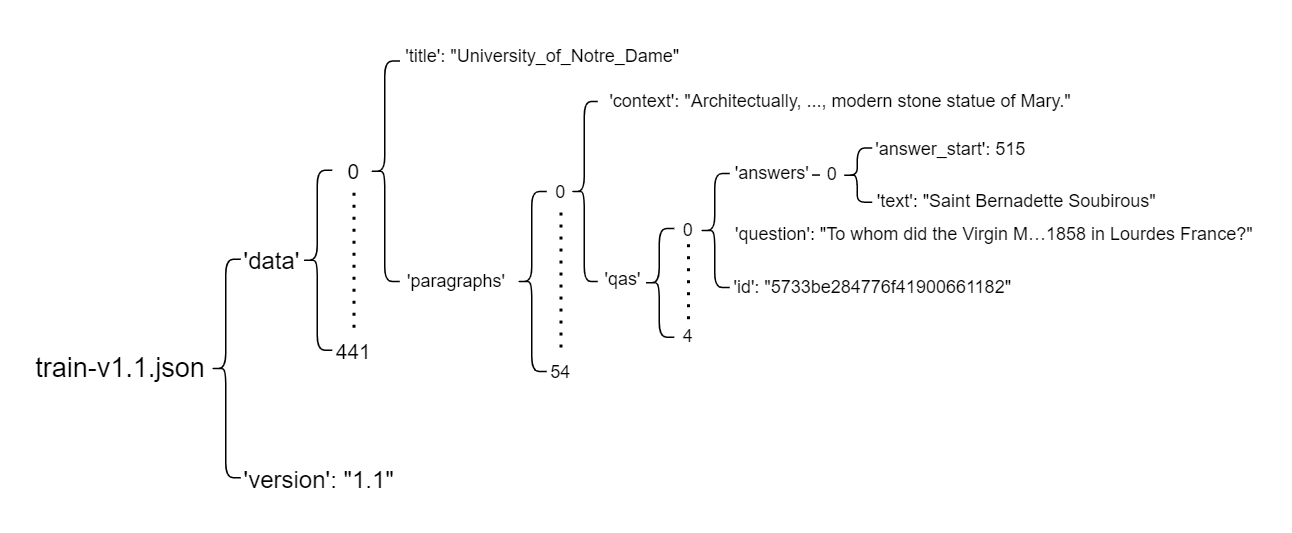

In [ ]:
print("title: "+squad['data'][0]['title'])
print("question: "+squad['data'][0]['paragraphs'][0]['qas'][0]['question'])
print("answer_start: "+str(squad['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']))
print("text: "+squad['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text'])
print("context: "+squad['data'][0]['paragraphs'][0]['context'][0:150])

title: University_of_Notre_Dame
question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer_start: 515
text: Saint Bernadette Soubirous
context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front o


### Generate training instances
*  A waste of space for duplicated reference passages, but generalized and easy to manage.

In [ ]:
question_list = []
context_list = []
answer_start_list = []
answer_end_list = []


for data in squad['data']:
    for cq_pair in data['paragraphs']:
    # cq_pair: 'context' + 'qas'
        for qa in cq_pair['qas']:
            # qa: 'answers' + 'question' + 'id'
            answer_start = qa['answers'][0]['answer_start']
            answer_len = len(qa['answers'][0]['text'])
            answer_end = answer_start + answer_len

            # 'question' + 'context' + 'answer_start' + 'answer_end'
            # restore the text of answer by indexing the context
            question_list.append(qa['question'])
            context_list.append(cq_pair['context'])
            answer_start_list.append(answer_start)
            answer_end_list.append(answer_end)

Take a look at the preprocessed data.

In [ ]:
idx=0
print("question: " + question_list[idx])
print("context: " + context_list[idx])
print("answer_start: " + str(answer_start_list[idx]))
print("answer_end: " + str(answer_end_list[idx]))

question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
answer_start: 515
answer_end: 541


In [ ]:
len(answer_start_list)

87599

### Tokenization

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('csarron/bert-base-uncased-squad-v1')

*   Tokenize the `question` and `context` pair.
    *   The seperation between question and answer is automatically handled.
    *   `truncation=True`: truncate the very long sequences for model to input.
    *   `padding=True`: append [PAD] tokens at the end to make all the inputs with shorter lengths have the same length.

In [ ]:
training_tokenized = tokenizer(question_list, context_list, truncation=True, padding=True)

### Explaining tokenization results

*   `input_ids`: tokens in values.
*   `token_type_ids`: 0 or 1, 0 for question and padding, 1 for passage.
*   `attention_mask`: 0 or 1, 0 for paddings, 1 for all other tokens(bidirectional attention).
  *  Given to model for not pay attention on padding tokens.

In [ ]:
training_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokenizer.decode(training_tokenized['input_ids'][0][0:17])

'[CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP]'

In [ ]:
training_tokenized['token_type_ids'][0][0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [ ]:
training_tokenized['attention_mask'][0][0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Set token index for the answers:
*   Convert the `answer_start` and `answer_end` from character index in the string to token index. 

In [ ]:
def add_answer_index(tokenized, answer_start, answer_end):
    start_token_list = []
    end_token_list = []
    for i in range(len(answer_start)):
    # Skip the question section by setting `sequence_index`=1
        start_token = training_tokenized.char_to_token(i, answer_start[i], 1)

        # if return is None, the answer passage containing the answer is truncated.
        if start_token is None:
            start_token_list.append(tokenizer.model_max_length)
        else:
            start_token_list.append(start_token)

        end_token = training_tokenized.char_to_token(i, answer_end[i] - 1, 1)
        if end_token is None:
            end_token_list.append(tokenizer.model_max_length)
        else:
            end_token_list.append(end_token)

    tokenized.update({'answer_start':start_token_list,'answer_end':end_token_list})

In [ ]:
add_answer_index(training_tokenized, answer_start_list, answer_end_list)

*   Display the result with a small function

In [ ]:
# Display the answer of the index of the question context pair
def show_answer(idx):
    start_idx = training_tokenized['answer_start'][idx]
    end_idx = training_tokenized['answer_end'][idx]
    answer_token_list = training_tokenized['input_ids'][idx][start_idx:end_idx+1]
    answer_tokens = tokenizer.convert_ids_to_tokens(answer_token_list)
    print(tokenizer.convert_tokens_to_string(answer_tokens))

In [ ]:
show_answer(0)

saint bernadette soubirous


### **Extension: Fine-tune the model with noised SQuAD**
*  Randomly select tokens in the context and change them to random tokens.
*  Question or answers are not selected for changing.
*  Motivation: still use the same dataset, but unlikely to overfit.

*   In the BERT tokenizer, the English words starts from index 1996, ends at 29611.
   *   Take a look at both bounds.

In [ ]:
tokenizer.convert_ids_to_tokens([1994, 1995, 1996, 1997])

['？', '～', 'the', 'of']

In [ ]:
tokenizer.convert_ids_to_tokens([29610, 29611, 29612, 29613])

['thyroid', 'necessitated', '##!', '##"']

*  `noise_ratio`: ratio of tokens selected to add noise, between 0 and 1.

In [ ]:
import math
import random

def add_noise_to_context(tokenized, noise_ratio=0.05):
    for i in range(len(tokenized['answer_start'])):
        # Skip the question section by searching in 'token_types'
        context_start = tokenized['token_type_ids'][i].index(1) - 1
        # 102 is the [SEP] token
        context_len = tokenized['input_ids'][i][context_start+1:].index(102)
        answer_len = tokenized['answer_end'][i] - tokenized['answer_start'][i] + 1

        # Sampling
        noise_num = math.floor(context_len*noise_ratio)
        noise_indices = random.sample(range(0,context_len-answer_len), noise_num)

        # Add noise
        input_ids = tokenized['input_ids']
        for t in noise_indices:
            new_token = random.choice(range(1996,29612))
            # Skip answers
            if t >= tokenized['answer_start'][i]:
                input_ids[i][t+context_start+answer_len] = new_token
            else:
                input_ids[i][t+context_start] = new_token
    
    tokenized.update({'input_ids':input_ids})

*   Create a deep copy of the dictionary and add noises
    *    This can take up RAM on Colab very fast, so for demo we run the next cell first.  

In [ ]:
# This is what we are supposed to do. But consumes too much CPU so train in 2 runs of this notebook.
# import copy
# noised_tokenized = copy.deepcopy(training_tokenized)
# add_noise_to_context(noised_tokenized, noise_ratio=0.05)

*   Take a look at the texts.

In [ ]:
tokenizer.decode(training_tokenized['input_ids'][0][17:175])

'architecturally, the school has a catholic character. atop the main building\'s gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend " venite ad me omnes ". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ), is a simple, modern stone statue of mary.'

In [ ]:
noised_tokenized = training_tokenized
add_noise_to_context(noised_tokenized, noise_ratio=0.05)

In [ ]:
tokenizer.decode(noised_tokenized['input_ids'][0][17:175])

'architecturally, the school has a catholic character. flinders the main building\'s gold dome is a golden statue of the virgin mary recalled immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend " venite ad me omnes " flynn next to the main building is the basilica of the sacred heart ache immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubiro patrolling in 1858. at the end of the main drive ( and in a direct line that cutting throughind statues and the gold dome ), is a simple, modern stone statue of mary.'

### Convert the data to a Pytorch dataset
*  To create a custom Pytorch Dataset, 2 methods must be overided:
  *  `__getitem__`: given an index, return the data at the index.
  *  `__len__`: return the length of the dataset.

In [ ]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data
    def __getitem__(self, idx):
        # Support indexing
        # Also convert to tensor.
        tokenized_index_data = {}
        for key, val in self.tokenized_data.items():
            tokenized_index_data.update({key: torch.tensor(val[idx])})
        return tokenized_index_data
    def __len__(self):
        return len(self.tokenized_data.answer_start)

In [ ]:
training_set_pure = SQuAD_Dataset(training_tokenized)
training_set_noise = SQuAD_Dataset(noised_tokenized)

*  Generate a DataLoader
   *  Iteratable, used to implement batch training.

In [ ]:
from torch.utils.data import DataLoader

train_loader_pure = DataLoader(training_set_pure, batch_size=1, shuffle=True)
train_loader_noise = DataLoader(training_set_noise, batch_size=1, shuffle=True)

## Fetch the pretrained model and improve it:

### Download the model

In [ ]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('csarron/bert-base-uncased-squad-v1')

*   Take a look at the structure

In [ ]:
print(model)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

### Set up training method

*  Output of `QuestionAnsweringModel`:
   *  Main items:
      *  `loss`: the loss of prediction, only returned during training
      *  `start_logits`: scores of each token as the start of the answer.
      *  `end_logits`: scores of each token as the end of the answer.
        *  Both scores are not the ones not passed to `softmax()`.
   *  Indexes of these items:
      *  When `start_positions` and `end_positions` are provided (training):
        *  `[loss, start_logits, end_logits]`
      *  When `start_positions` and `end_positions` are absent (predicting):
        *  `[start_logits, end_logits]`

In [ ]:
def torch_train(model, optimizer, train_loader, epochs=3):
    model.to(device)
    for i in range(epochs):
        loop = tqdm(train_loader)
        for batch in loop:
            # Retrieve features and labels
            # Features
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            
            # Labels
            answer_start = batch['answer_start'].to(device)
            answer_end = batch['answer_end'].to(device)

            # Predict by model
            output = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, start_positions=answer_start, end_positions=answer_end)

            # Obtain the loss
            loss = output[0]

            # Find gradients and backpropagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Set progress bar
            loop.set_description(f'Epoch {i+1}')
            loop.set_postfix(loss=loss.item())

### Train the model with original SQuAD
*  **The next block fine-tunes the model, taking a long time.**

*  Adam optimizer:
*   Combines the ideas of Momentum optimization and RMSProp.
    *   Momentum: keeps track of an exponentially decaying average of past gradients.
    *   RMSProp: keeps track of an exponentially decaying average of past squared gradients.
    *   $m$ and $s$ are initialized with $\vec 0$.
    *   Therefore, $\hat m$ and $\hat s$ are used for unbiasness.
    *   Hyperparamters: $\beta_1$ and $\beta_2$ are typically set to $\beta_1=0.9$, $\beta_2=0.999$.

<br>

*   $m\leftarrow \beta_1m-(1-\beta_1) \nabla J(\theta)$
*   $s\leftarrow \beta_2s+(1-\beta_2) \nabla J(\theta) \otimes \nabla J(\theta)$
*   $\hat m\leftarrow \frac{m}{1-{\beta_1}^t}$
*   $\hat s\leftarrow \frac{s}{1-{\beta_2}^t}$
*   $\theta \leftarrow \theta + \eta \hat m \oslash \sqrt{\hat s+\epsilon}$

<br>

*   where $\otimes$ is element-wise multiplication and $\oslash$ is element-wise division.
*   $\epsilon$ is an arbitrarily small number to prevent dividing by zero.

In [ ]:
model_pure = BertForQuestionAnswering.from_pretrained('csarron/bert-base-uncased-squad-v1')

# Pass the parameters of the model to optimizer
adam1 = torch.optim.AdamW(model_pure.parameters(), lr=1e-6)

model_pure.train()
torch_train(model=model_pure, optimizer=adam1, train_loader=train_loader_pure, epochs=1)

*   Save model and tokenizer

In [ ]:
if "google.colab" in sys.modules:
    model_path_1 = '/content/drive/MyDrive/CISC 452/pure_training'
else:
    model_path_1 = './pure_training'

model_pure.save_pretrained(model_path_1)
tokenizer.save_pretrained(model_path_1)

### Train the model with noised SQuAD
*  The next block fine-tunes the model, taking a long time.
*  Extended model is saved. Load it in "Demo" section.

In [ ]:
model_noise = BertForQuestionAnswering.from_pretrained('csarron/bert-base-uncased-squad-v1')

# Pass the parameters of the model to optimizer
adam2 = torch.optim.AdamW(model_noise.parameters(), lr=1e-6)

model_noise.train()
torch_train(model=model_noise, optimizer=adam2, train_loader=train_loader_noise, epochs=2)

Epoch 2: 100%|████████████████████████████████████████████████████| 87599/87599 [4:54:18<00:00,  4.96it/s, loss=0.0208]


*  Save the model and tokenizer

In [ ]:
if "google.colab" in sys.modules:
    model_path_2 = '/content/drive/MyDrive/CISC 452/noise_training'
else:
    model_path_2 = './noise_training'

model_noise.save_pretrained(model_path_2)
tokenizer.save_pretrained(model_path_2)

('./noise_training\\tokenizer_config.json',
 './noise_training\\special_tokens_map.json',
 './noise_training\\vocab.txt',
 './noise_training\\added_tokens.json',
 './noise_training\\tokenizer.json')

## Evaluate our model and Demo
*   Dataset to evaluate: "dev-v1.1.json".

### Load our model

In [ ]:
# In case we skipped previous blocks.
from transformers import BertTokenizerFast
from transformers import BertForQuestionAnswering

In [ ]:
if "google.colab" in sys.modules:
   model_path = '/content/drive/MyDrive/CISC 452/Prj24/Mengyang/noise_training'
else:
   model_path = './noise_training'

model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

### Download "dev-v1.1.json" and read it

In [ ]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json

--2022-12-05 02:52:15--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [application/json]
Saving to: ‘dev-v1.1.json’

dev-v1.1.json       100%[===================>]   4.63M  --.-KB/s    in 0.06s   

2022-12-05 02:52:16 (75.7 MB/s) - ‘dev-v1.1.json’ saved [4854279/4854279]



In [ ]:
with open('dev-v1.1.json', 'rb') as f:
      squad_dev = json.load(f)

### Write a prediction function and Demo with question and answers

In [ ]:
def get_answer(model, tokenizer, question, context):
    # Preprocess
    tokenized = tokenizer(question, context, truncation=True)
    input_ids = tokenized['input_ids']
    token_type_ids = tokenized['token_type_ids']

    input_ids_tensor = torch.tensor([input_ids]).to(device)
    token_type_ids_tensor = torch.tensor([token_type_ids]).to(device)

    # Predict
    output = model(input_ids_tensor, token_type_ids=token_type_ids_tensor)

    answer_start = torch.argmax(output[0])  
    answer_end = torch.argmax(output[1])

    # Generate answer text
    answer_tokens = tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end+1])
    answer = tokenizer.convert_tokens_to_string(answer_tokens)

    return answer

Example 1:
* Question:
  * What is the advantage of virtual memory?
* Context:
  * **Virtual memory** is a technique that allows the execution of processes that are not completely in memory. **One major advantage of this scheme** is that **programs can be larger than physical memory**. Further, virtual memory abstracts main memory into an extremely large, uniform array of storage, separating logical memory as viewed by the user from physical memory. This technique frees programmers from the concerns of memory-storage limitations. Virtual memory also allows processes to share files easily and to implement shared memory. In addition, it provides an efficient mechanism for process creation. Virtual memory is not easy to implement, however, and may substantially decrease performance if it is used carelessly.

Example 2:
*  Question
  *  What happens under nonpreemptive scheduling?
*  Context
  *  When scheduling takes place only under circumstances 1 and 4, we say that the scheduling scheme is nonpreemptive or cooperative. Otherwise, it is preemptive. **Under nonpreemptive scheduling, once the CPU has been allocated to a process, the process keeps the CPU until it releases the CPU either by terminating or by switching to the waiting state.** This scheduling method was used by Microsoft Windows 3.x. Windows 95 introduced preemptive scheduling, and all subsequent versions of Windows operating systems have used preemptive scheduling. The Mac OS X operating system for the Macintosh also uses preemptive scheduling; previous versions of the Macintosh operating system relied on cooperative scheduling. Cooperative scheduling is the only method that can be used on certain hardware platforms, because it does not require the special hardware (for example, a timer) needed for preemptive scheduling.

In [ ]:
model.to(device)
print("Done")

Done


In [ ]:
question1 = "What is the advantage of virtual memory?"
context1 = "Virtual memory is a technique that allows the execution of processes that are not completely in memory. One major advantage of this scheme is that programs can be larger than physical memory. Further, virtual memory abstracts main memory into an extremely large, uniform array of storage, separating logical memory as viewed by the user from physical memory. This technique frees programmers from the concerns of memory-storage limitations. Virtual memory also allows processes to share files easily and to implement shared memory. In addition, it provides an efficient mechanism for process creation. Virtual memory is not easy to implement, however, and may substantially decrease performance if it is used carelessly."

In [ ]:
get_answer(model, tokenizer, question1, context1)

'programs can be larger than physical memory'

In [ ]:
question2 = "What happens under nonpreemptive scheduling?"
context2 = "When scheduling takes place only under circumstances 1 and 4, we say that the scheduling scheme is nonpreemptive or cooperative. Otherwise, it is preemptive. Under nonpreemptive scheduling, once the CPU has been allocated to a process, the process keeps the CPU until it releases the CPU either by terminating or by switching to the waiting state. This scheduling method was used by Microsoft Windows 3.x. Windows 95 introduced preemptive scheduling, and all subsequent versions of Windows operating systems have used preemptive scheduling. The Mac OS X operating system for the Macintosh also uses preemptive scheduling; previous versions of the Macintosh operating system relied on cooperative scheduling. Cooperative scheduling is the only method that can be used on certain hardware platforms, because it does not require the special hardware (for example, a timer) needed for preemptive scheduling." 

In [ ]:
get_answer(model, tokenizer, question2, context2)

'the process keeps the cpu until it releases the cpu either by terminating or by switching to the waiting state'

### Prepare the predictions to evaluate

*   Input format to evaluate:
*   `evaluate(dataset, predictions)`
    *   `dataset`: a list of dictionaries that maps `paragraphs` to a list of `qas`.
    *   `predictions`: a dictionary that maps "id" to answer text.

In [ ]:
dataset = squad_dev["data"]

In [ ]:
def get_predictions (model, tokenizer, squad_dev):
    predictions = {}
    for data in squad_dev['data']:
        for cq_pair in data['paragraphs']:
        # cq_pair: 'context' + 'qas'
            for qa in cq_pair['qas']:
                # qa: 'answers' + 'question' + 'id'
                qa_id = qa['id']
                qa_question = qa['question']
                qa_context = cq_pair['context']

                # generate answer text
                qa_answer = get_answer(model, tokenizer, qa_question, qa_context)
                
                # Update predictions
                predictions.update({qa_id: qa_answer})
    return predictions

### Start evaluation
*   Evaluate with the official evaluation script "evaluate-v1.1.py".
    *   Rename to "squad11_evaluate.py" for import convinence.

In [ ]:
from squad11_evaluate import evaluate

*   Imported model(no extention as a baseline)

In [ ]:
model_import = BertForQuestionAnswering.from_pretrained('csarron/bert-base-uncased-squad-v1')
tokenizer = BertTokenizerFast.from_pretrained('csarron/bert-base-uncased-squad-v1')

In [ ]:
model_import.to(device)
model_import.eval()
predictions_import = get_predictions(model_import, tokenizer, squad_dev)
evaluate(dataset, predictions_import)

{'exact_match': 71.01229895931883, 'f1': 80.73672946098795}

*   Model fine-funed with vanilla SQuADv1.1
    *    Overfitting.

In [ ]:
if "google.colab" in sys.modules:
    model_path_1 = '/content/drive/MyDrive/CISC 452/pure_training'
else:
    model_path_1 = './pure_training'

model_pure = BertForQuestionAnswering.from_pretrained(model_path_1)

In [ ]:
model_pure.to(device)
model_pure.eval()
predictions_pure = get_predictions(model_pure, tokenizer, squad_dev)
evaluate(dataset, predictions_pure)

{'exact_match': 70.879848628193, 'f1': 80.71028171762157}

*   Model fine-tuned with noised SQuADv1.1
    *    Results improved!

In [ ]:
if "google.colab" in sys.modules:
    model_path_2 = '/content/drive/MyDrive/CISC 452/noise_training'
else:
    model_path_2 = './noise_training'

model_noise = BertForQuestionAnswering.from_pretrained(model_path_2)

In [ ]:
model_noise.to(device)
model_noise.eval()
predictions_noise = get_predictions(model_noise, tokenizer, squad_dev)
evaluate(dataset, predictions_noise)

{'exact_match': 71.03122043519394, 'f1': 81.00768535412396}